In [1]:
from dotenv import load_dotenv

load_dotenv()

True

### Set graph state

In [2]:
from typing import TypedDict
from langchain_openai import ChatOpenAI

class AgentState(TypedDict):
    question: str
    certainty_score: int
    search_results: list
    web_score: str
    repo_name: str
    generation: str

llm = ChatOpenAI(model="gpt-4o", temperature=0)

### Answer trust check

In [3]:
from typing import Literal
from pydantic import BaseModel, Field

def check_certainty(state: AgentState) -> AgentState:
    """Evaluate certainty score for the query."""
    
    question = state['question']

    class CertaintyScoreResponse(BaseModel):
        score: int = Field(description="Certainty score from 1 to 100. Higher is better.")

    certainty_scorer = llm.with_structured_output(CertaintyScoreResponse)

    print("---CHECKING LLM'S CERTAINTY")
    score_response = certainty_scorer.invoke(question)

    return {"certainty_score": score_response.score}

def route_based_on_certainty(state: AgentState) -> Literal["web_search", "direct_response"]:
    """Route to appropriate node based on certainty score."""
    
    score = state['certainty_score']

    if score != 100:
        print("---LLM IS NOT CERTAIN SO IT WILL DO WEB SEARCH")
        return "web_search"
    else:
        print("---LLM IS CERTAIN SO IT WILL GENERATE ANSWER DIRECTLY")
        return "direct_response"

In [4]:
question = "Langgraph로 RAG를 구축하는 방법"

class CertaintyScoreResponse(BaseModel):
    score: int = Field(description="Certainty score from 1 to 100. Higher is better.")

certainty_scorer = llm.with_structured_output(CertaintyScoreResponse)

print("---CHECKING LLM'S CERTAINTY")
score_response = certainty_scorer.invoke(question)
score_response

---CHECKING LLM'S CERTAINTY


CertaintyScoreResponse(score=85)

In [6]:
# If LLM can answer on its own
def direct_response(state: AgentState):
    question = state['question']
    result = llm.invoke(question)
    return {"generation": result.content}

### Determining whether an answer is available based on a web search

In [7]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_community.tools.tavily_search import TavilySearchResults

def web_search(state: AgentState) -> AgentState:
    """Perform web search and evaluate results"""

    question = state['question']

    search_tool = TavilySearchResults(max_results=3)
    search_results = search_tool.invoke(question)

    class answer_availability(BaseModel):
        """Binary score for answer availability"""
        binary_score: str = Field(description="""
                                  If web search result can solve the user's ask, answer 'yes'.
                                  If not, answer 'no'""")

    evaluator = llm.with_structured_output(answer_availability)
    eval_prompt = ChatPromptTemplate.from_messages([
        ("system", "Evaluate if these search results can answer the user's question with a simple yes/no."),
        ("user", """
        Question: {question}
        Search Results: {results}
        Can these results answer the question adequately?
        """)
    ])
    print("---CHECK WHETHER WEB SEARCH IS SUFFICIENT FOR USER'S ASK")
    evaluation = evaluator.invoke(
        eval_prompt.format(
            question=question, results="\n".join(f"- {result['content']}" for result in search_results)
        )
    )

    return {
        "search_results": search_results,
        "web_score": evaluation.binary_score
    }

### Whether it can be solved by web search

In [9]:
question = "autorag github에서 명시된 설치 방법을 알려줘"

search_tool = TavilySearchResults(max_results=3)
search_results = search_tool.invoke(question)


class answer_availability(BaseModel):
    """Binary score for answer availability."""
    binary_score: str = Field(description="""
                                If web search result can solve the user's ask, answer 'yes'. 
                                If user's ask is related with github or search_results are insufficient, answer 'no'""")

evaluator = llm.with_structured_output(answer_availability)
eval_prompt = ChatPromptTemplate.from_messages([
    ("system", """
        Evaluate if these search results can answer the user's question with a simple yes/no. 
        If user ask github related info, then it is not sufficient with web search so you should answer with no."""),
    ("user", """
    Question: {question}
    Search Results: {results}
    Can these results answer the question adequately?
    """)
])
print("---CHECK WHETHER WEB SEARCH IS SUFFICIENT FOR USER'S ASK")

evaluation = evaluator.invoke(
    eval_prompt.format(
        question=question, results="\n".join(f"- {result['content']}" for result in search_results)
    )
)

---CHECK WHETHER WEB SEARCH IS SUFFICIENT FOR USER'S ASK


In [10]:
evaluation

answer_availability(binary_score='no')

### Routing node

In [11]:
def route_after_search(state: AgentState) -> Literal["generate", "github_search"]:
    """Route based on search evaluation"""
    if state["web_score"] == "yes":
        print("---DECISION: THIS CAN BE SOLVED WITH WEB SEARCH RESULTS")
        return "web_generate"
    else:
        print("---DECISION: THIS CAN NOT BE SOLVED WITH WEB SEARCH RESULTS. FIND GITHUB")
        return "github_generate"

### Web generate node

In [12]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

def web_generate(state: AgentState):
    question = state["question"]
    web_results = state["search_results"]

    def format_web_results(results):
        formatted = []
        for i, result in enumerate(results, 1):
            formatted.append(f"Source {i}:\nURL: {result['url']}\nContent: {result['content']}\n")
        return "\n".join(formatted)

    prompt = ChatPromptTemplate.from_messages([
        ("system", """You are a helpful assistant that generates comprehensive answers based on web search results.
        Use the provided search results to answer the user's question.
        Make sure to synthesize information from multiple sources when possible.
        If the search results don't contain enough information to fully answer the question, acknowledge this limitation."""),
        ("user", """Question: {question}

        Search Results:
        {web_results}

        Please provide a detailed answer based on these search results. Answer in Korean""")
    ])

    chain = (
        {
            "question": lambda x: x["question"],
            "web_results": lambda x: format_web_results(x["web_results"])
        }
        | prompt
        | llm
        | StrOutputParser()
    )

    print("---GENERATING ANSWER BASED ON WEB SEARCH RESULTS...")

    response = chain.invoke({
        "question": question,
        "web_results": web_results
    })

    return {"generation": response}

### Get Github repo info

In [13]:
import os

import chromadb
from chromadb.config import Settings

from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma
from langchain_community.document_loaders import GithubFileLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

def git_loader(repo, branch_name):
    loader = GithubFileLoader(
        repo=repo,
        branch=branch_name,
        access_token=os.environ["GITHUB_TOKEN"],
        github_api_url="https://api.github.com",
        file_filter=lambda file_path: file_path.endswith(
            ".md"
        ),
    )
    documents = loader.load()
    return documents

def git_vector_embedding(repo_name):
    client = chromadb.Client(Settings(
        is_persistent=True,
        persist_directory="./chroma_db"
    ))

    collection_name = repo_name.split('/')[1]

    existing_collections = client.list_collections()
    if collection_name in [col.name for col in existing_collections]:
        print(f"Loading existing collection for {collection_name}")
        vectorstore = Chroma(
            client=client,
            collection_name=collection_name,
            embedding_function=OpenAIEmbeddings()
        )
    else:
        print(f"Creating new collection for {collection_name}")
        try:
            git_docs = git_loader(repo_name, "master")
        except:
            git_docs = git_loader(repo_name, "main")

        text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
            chunk_size=500, chunk_overlap=50
        )
        doc_splits = text_splitter.split_documents(git_docs)

        vectorstore = Chroma.from_documents(
            documents=doc_splits,
            collection_name=collection_name,
            embedding=OpenAIEmbeddings(),
            client=client
        )

    return vectorstore

### Generate answer based on github repo info

In [22]:
from langchain import hub

def github_generate(state: AgentState) -> AgentState:
    """Find relevant GitHub repositories for the user's question."""

    class GitHubRepo(BaseModel):
        """Best matching GitHub repository"""
        repo_name: str = Field(description="Full repository name in format 'owner/repo'")

    question = state["question"]

    # Perform targeted web search for GitHub repositories
    search_tool = TavilySearchResults(max_results=5)
    search_results = search_tool.invoke(
        f"github repository {question} site:github.com"
    )

    # Extract and evaluate repositories from search results
    eval_prompt = ChatPromptTemplate.from_messages([
        ("system", """You are an expert at identifying the most relevant GitHub repository.
        Analyze the search results and identify the SINGLE MOST RELEVANT GitHub repository.
        Return ONLY the repository name in the format 'owner/repo'."""),
        ("user", """
        Question: {question}
        Search Results: {results}
        
        What is the most relevant repository name?""")
    ])

    repo_extractor = llm.with_structured_output(GitHubRepo)

    best_repo = repo_extractor.invoke(
        eval_prompt.format(
            question=question,
            results="\n\n".join(f"URL: {result['url']}\nContent: {result['content']}"
                                for result in search_results)
        )
    )
    repo_name = best_repo.repo_name
    vectorstore = git_vector_embedding(repo_name)
    retriever = vectorstore.as_retriever()
    prompt = hub.pull("rlm/rag-prompt")

    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    rag_chain = (
        {"context": retriever | format_docs, "question": RunnablePassthrough()}
        | prompt
        | llm
        | StrOutputParser()
    )
    print("---GENERATING ANSWER BASED ON GITHUB REPO SEARCH RESULT")
    result = rag_chain.invoke(question)
    
    return {"generation": result}

### Building graph

In [23]:
from langgraph.graph import START, END, StateGraph

workflow = StateGraph(AgentState)

workflow.add_node("check_certainty", check_certainty)
workflow.add_node("direct_response", direct_response)
workflow.add_node("web_search", web_search)
workflow.add_node("web_generate", web_generate)
workflow.add_node("github_generate", github_generate)

workflow.add_edge(START, "check_certainty")
workflow.add_conditional_edges(
    "check_certainty",
    route_based_on_certainty,
    {
        "web_search": "web_search",
        "direct_response": "direct_response"
    }
)
workflow.add_conditional_edges(
    "web_search",
    route_after_search,
    {
        "web_generate": "web_generate",
        "github_generate": "github_generate"
    }
)

workflow.add_edge("direct_response", END)
workflow.add_edge("web_generate", END)
workflow.add_edge("github_generate", END)

app = workflow.compile()

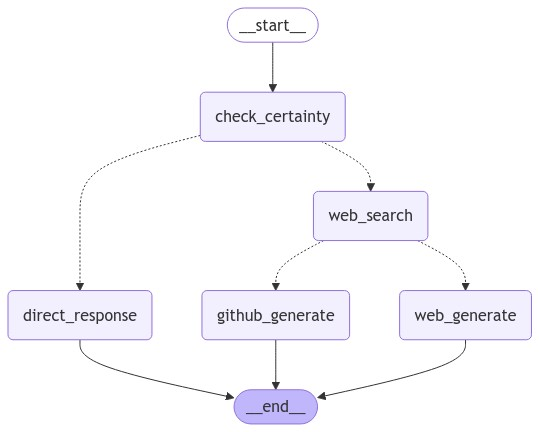

In [24]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [25]:
from pprint import pprint

inputs = {
    "question": "Do you know how to run YOLO v8 segmentation model from Ultralytics in a real-time environment? Can you give me the exact code?"
}

for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Output from node '{key}':")
        pprint("-" * 80)
        pprint(value, indent=2, width=80, depth=None)
    pprint("\n---\n")

---CHECKING LLM'S CERTAINTY
---LLM IS NOT CERTAIN SO IT WILL DO WEB SEARCH
"Output from node 'check_certainty':"
'--------------------------------------------------------------------------------'
{'certainty_score': 85}
'\n---\n'
---CHECK WHETHER WEB SEARCH IS SUFFICIENT FOR USER'S ASK
---DECISION: THIS CAN NOT BE SOLVED WITH WEB SEARCH RESULTS. FIND GITHUB
"Output from node 'web_search':"
'--------------------------------------------------------------------------------'
{ 'search_results': [ { 'content': 'from ultralytics import YOLO # Load a '
                                   'pretrained YOLO model model = '
                                   'YOLO("yolov8n.pt") 4. Perform Object '
                                   'Detection on an Image: Use the model to '
                                   'perform object detection on an image. '
                                   'Here, an',
                        'url': 'https://medium.com/@asbmerin/to-get-started-with-yolov8-for-object-detec